In [1]:
%matplotlib inline

# Convolutional Neural Network with Keras

In this exercise, we will build a convolutional neural network (CNN) to classify the handwritten digits from MNIST. The initial parts (imports and load) are the same as what we did on the NN exercise.

## Imports
First let's import some prerequisites:

In [2]:
import numpy as np
from random import shuffle, seed
seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import optimizers

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Load training data

In [3]:
nb_classes = 10

# the data, shuffled and split between trainVal and test sets
(trainVal_data, trainVal_label), (X_test, y_test) = mnist.load_data()

# We want now to split the trainVal data into train and validation sets
nData = trainVal_data.shape[0]  #find the size of trainVal
nTrain = int(nData * 0.8)  #80% to train, 20% to val

randomIdx = list(range(nData))   #randomly select indexes
shuffle(randomIdx)
trainIdx = randomIdx[:nTrain] 
valIdx = randomIdx[nTrain:]

# Split the data
X_val, y_val = trainVal_data[valIdx], trainVal_label[valIdx]
X_train, y_train = trainVal_data[trainIdx], trainVal_label[trainIdx]

print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape), "\n"

print("X_val original shape", X_val.shape)
print("y_val original shape", y_val.shape), "\n"

print("X_test original shape", X_test.shape)
print("y_test original shape", y_test.shape)

X_train original shape (48000, 28, 28)
y_train original shape (48000,)
X_val original shape (12000, 28, 28)
y_val original shape (12000,)
X_test original shape (10000, 28, 28)
y_test original shape (10000,)


Let's look at some examples of the training data:

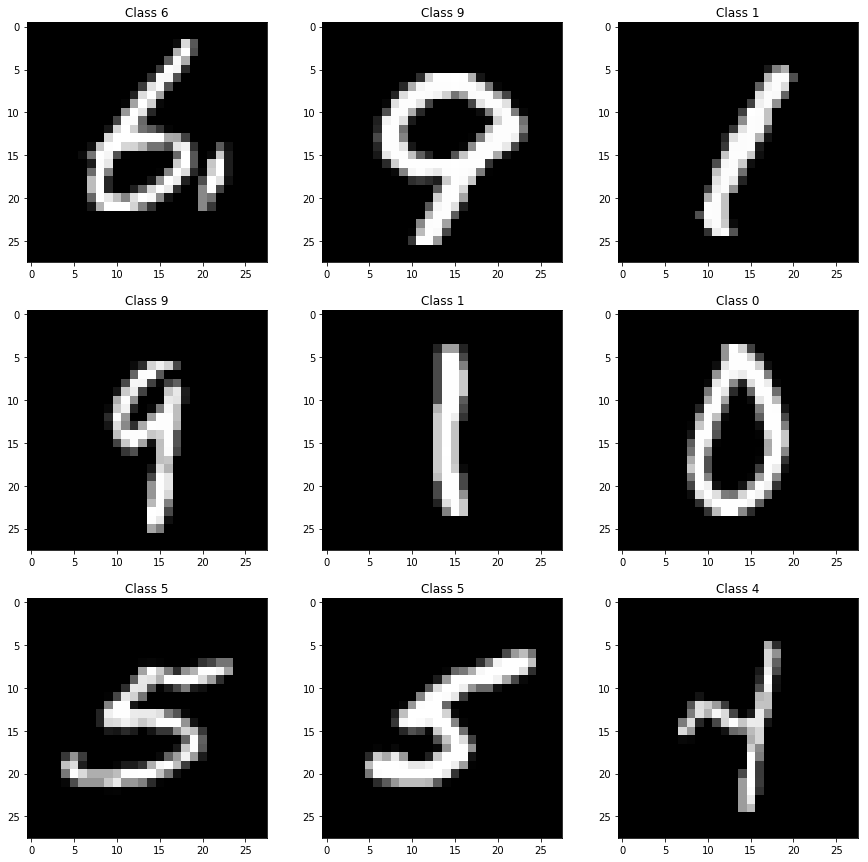

In [4]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

## How balanced is our training?
Let's check how many examples we have for each class and calculate a class weight. This can be useful to tell the model to "pay more attention" during training to samples from an under-represented class.

In [5]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train ---> ", dict(zip(unique, counts)), "\n")


from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights, "\n")

Train --->  {0: 4724, 1: 5393, 2: 4723, 3: 4881, 4: 4704, 5: 4313, 6: 4769, 7: 5001, 8: 4730, 9: 4762} 

{0: 1.0160880609652836, 1: 0.8900426478768775, 2: 1.0163031971204743, 3: 0.9834050399508297, 4: 1.0204081632653061, 5: 1.1129144447020636, 6: 1.0065003145313483, 7: 0.9598080383923215, 8: 1.014799154334038, 9: 1.0079798404031919} 



In [6]:
#For the test set ---> We will use this to find the normalized accuracy
unique, counts = np.unique(y_test, return_counts=True)
print("Test ---> ", dict(zip(unique, counts)), "\n")

test_sample_per_class = counts
print(test_sample_per_class)

Test --->  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009} 

[ 980 1135 1032 1010  982  892  958 1028  974 1009]


## Preprocessing data for training
Differently to what we did in our neural network, the CNN operates on images as input, so it is not necessary to transform the image to an array. However we need to inform to our network the shape of our images. Colored images usually have 3 channels (RGB), but we are working with grayscale images which have only a single channel. **An important point to notice**, Tensorflow assumes the number of channels are always as the last dimension of the image, while Torch assumes it is in the first dimension:

```
Tensorflow -> (img_rows, img_cols, channels)
Torch -> (channels, img_rows, img_cols)
```

Besides that, just like we did before, we are going to scale the inputs to be in the range [0-1] rather than [0-255]. **Other types of preprocessing, such as scaling, normalization and cropping could also be done in this part.**

In [7]:
img_rows, img_cols = 28, 28

#The first dimension refers to the number of images
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (48000, 28, 28, 1)
Validation matrix shape (12000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


Let's also modify the target matrices to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]
...
9 -> [0, 0, 0, 0, 0, 0, 0, 0, 1]
```

Keras already has a method to do this, `np_utils.to_categorical`:

In [8]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Define the architecture
We will define a simple CNN with the layers that we have learned so far. Our network will have:
- Convolutional layer with 10 filters of size 5x5, followed by ReLU activation;
- Max pooling layer with kernel 2x2, that will reduce each spatial dimension by half (24x24 to 12x12);
- An operation to flatten the feature maps into an array of size 10x12x12 = 1440
- Dropout operation with probability 0.25, applied to flattened array
- Fully connected layer with units/neurons equal to the number of classes in our problem (in this case, 10);
- Softmax activation on the last FC layer.

The architecture will look like this:

<img src="cnn_mnist.png" />

In [9]:
model = Sequential()
model.add(Conv2D(10, kernel_size=(24,24), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

**It is important to notice** that most layers allow us to define the activation (ReLU, sigmoid, softmax) by passing a string to the `activation` argument. On the Neural Network exercise, we defined it by doing a `model.add(Activation('sigmoid'))`.

## Compile the model
Let's define the loss and optimizer we will use to train our CNN, as well as specify that we want to record the accuracy in each epoch. We will use the categorial cross-entropy as our loss and the SGD optimizer. **Remember that Keras does not output the normalized accuracy!!**

In [10]:
sgd = optimizers.SGD(lr=0.01) #lr = learning rate
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#Similar to the layers, we can define the optimizer with a string 'sgd'
# which will give us the SGD optimizer with default parameters
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

## Train the model!
We are ready to train our CNN! Just like in the NN, the `model.fit` method receives the same arguments:
- **X_train & Y_train:** the training data and labels;
- **batch_size:** instead of optimizing your network on all training data, we usually optimize it over batches (small samples from the training data). In this case, we will update our weights (backpropagation) after forwarding/processing 128 images;
- **nb_epoch:** an epoch occurs when all your training data is processed/forwarded once. As CNNs are more computationally expensive than NNs, we will only process 1 epoch.
- **verbose:** show loss after each epoch
- **class_weight:** the weight of each class, considering they are not balanced. This will ponder the loss based on how frequent each class is;
- **validation_data:** after each epoch our model will predict these data and output the loss and accuracy

In [11]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=1, verbose=1,
          class_weight = train_class_weights,
          validation_data=(X_val, Y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/1
48000/48000 [==============================] - 5s 97us/step - loss: 1.6086 - acc: 0.4849 - val_loss: 0.9316 - val_acc: 0.8045


## Finally, evaluate its performance on the test data

In [12]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NOT NORMALIZED):', score[1])

10000/10000 [==============================] - 0s 45us/step
Test loss: 0.9153460832595826
Test accuracy (NOT NORMALIZED): 0.8082


## Normalized Accuracy

In [13]:
predicted_classes = model.predict_classes(X_test)
Y_test_classes = np.argmax(Y_test, axis=-1)

accPerClass = []
for classIdx in range(nb_classes):
    idx = (Y_test_classes == classIdx)
    
    correctPred = np.sum(predicted_classes[idx] == Y_test_classes[idx])
    accPerClass.append( correctPred / float(test_sample_per_class[classIdx]))
    
print(dict(zip(range(nb_classes),accPerClass)), "\n")
print ("Normalized Acc --> ", np.mean(accPerClass))

{0: 0.9204081632653062, 1: 0.9656387665198238, 2: 0.624031007751938, 3: 0.8584158415841584, 4: 0.8258655804480651, 5: 0.7085201793721974, 6: 0.8152400835073069, 7: 0.8258754863813229, 8: 0.7464065708418891, 9: 0.7661050545094152} 

Normalized Acc -->  0.8056506734181422


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [14]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

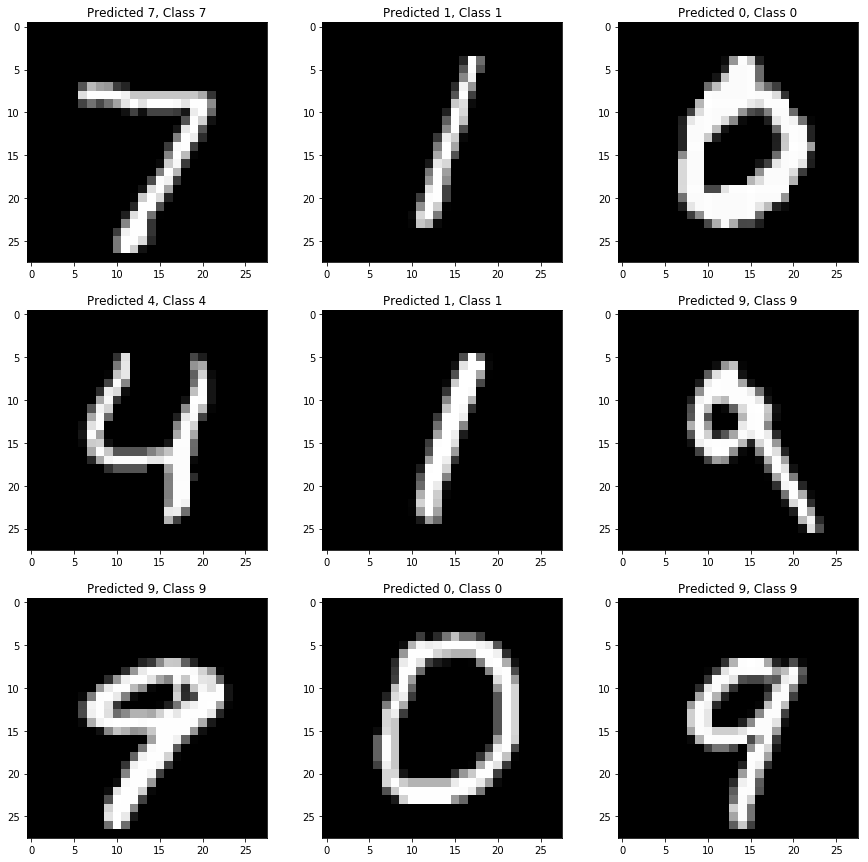

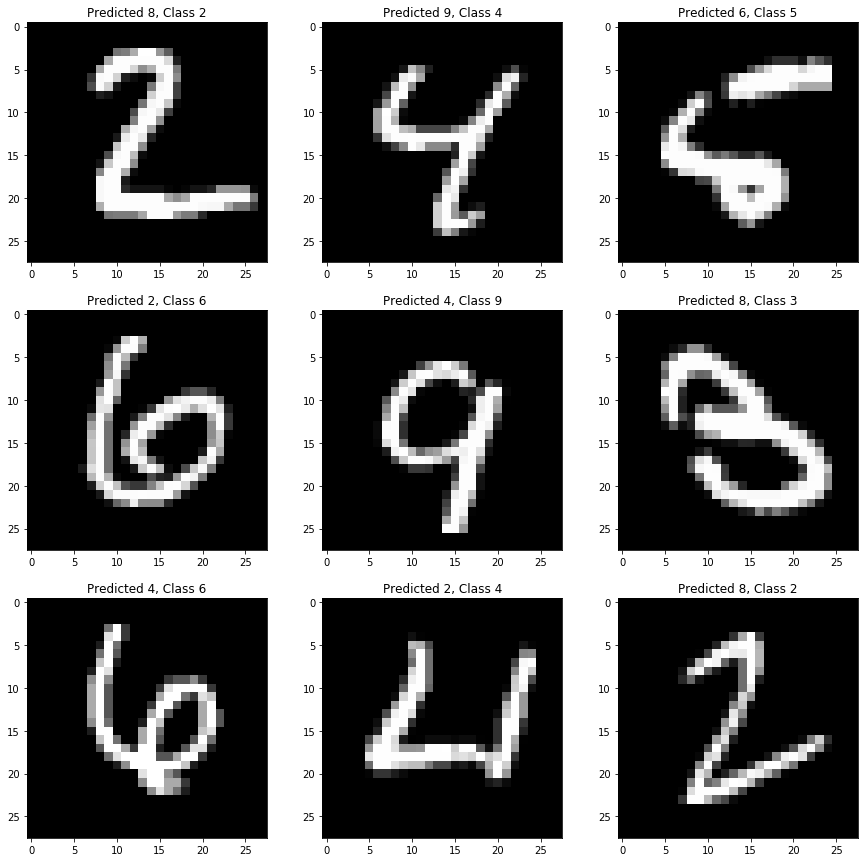

In [15]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

# References

- This notebook was heavily inspired in [Keras tutorial on CNN](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py);
- The image of the CNN architecture was adapted from [here](https://codetolight.wordpress.com/2017/11/29/getting-started-with-pytorch-for-deep-learning-part-3-neural-network-basics/).